For each practical exercise (TP), please work in groups of two or three. Then, create a **private GitHub repository** and add me (my GitHub is **arthur-75**) to your project. Finally, share the link to your project (or TP) under  [Practical Exercises](https://docs.google.com/spreadsheets/d/1V-YKgHn71FnwjoFltDhWsPJS7uIuAh9lj6SP2DSCvlY/edit?usp=sharing) and make sure to choose your **team name** :-)

# **Practical Exercise: GAN on Lego Brick Images**

### **Goal**

Train a DCGAN (Deep Convolutional GAN) to generate **64×64** grayscale images of **Lego bricks**.

## **1\. Understanding the Dataset**

* **Data**: A Kaggle dataset containing many **png/jpg** images of lego bricks.  
* **Tasks**:  
  1. **Load** all images from a folder (since you only need images, no labels required).  
  2. **Transform** images:  
     * Convert to **grayscale** (one channel).  
     * **Resize** to 64×64.  
     * **Normalize** the pixel range, usually to \[−1,1\]\[−1,1\] or \[0,1\]\[0,1\]. Which one should you  pick here and why ? 


In [ ]:
pip install kaggle
!kaggle datasets download -d joosthazelzet/lego-brick-images --unzip

In [13]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as vutils
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

# --------------------
#   Hyperparameters
# --------------------
IMAGE_SIZE = 64       # Input/Output resolution
CHANNELS = 1          # Grayscale = 1, for color use 3
BATCH_SIZE = 128
Z_DIM = 100           # Dim of latent vector
EPOCHS = 100
LEARNING_RATE = 0.0002
BETA1 = 0.5
BETA2 = 0.999
DEVICE = "cuda"  # or "cuda" if torch.cuda.is_available() else "cpu"
NOISE_PARAM = 0.1     # Label smoothing/noise
# --------------------
#   Transforms
# --------------------
# Define the transforms: Grayscale + Resize + Normalize
transform = transforms.Compose([
    transforms.Grayscale(1), # Grayscale
    transforms.Resize((64,64)), # Resiz
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) # Center around 0 with range [-1,1]
])

3\. Build Dataset & DataLoader  
Simple custom dataset that returns images (no labels) from a specified folder

In [ ]:

# --------------------
# Dataset & DataLoader
#--------------------

class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        # Gather all image files with .png, .jpg, .jpeg
        self.image_files = sorted([
            f for f in os.listdir(root_dir) 
            if f.endswith(('.png', '.jpg', '.jpeg'))
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")  # or "L" for grayscale
        if self.transform:
            image = self.transform(image)
        return image

# Specify your dataset folder path
dataset_path = "dataset"
dataset = ImageDataset(root_dir=dataset_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

4\. Plot few example

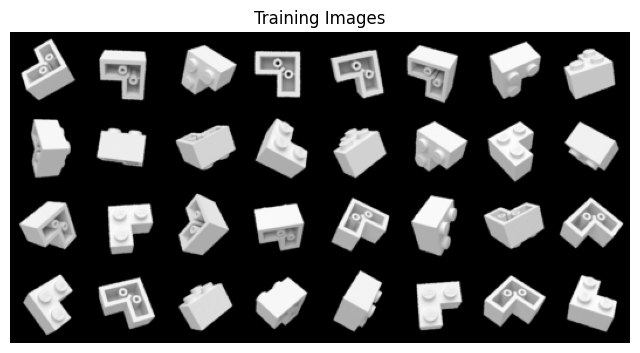

In [16]:
def plot_sample_images(loader):
    data = next(iter(loader))
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title("Training Images")
    
    plt.imshow(np.transpose(vutils.make_grid(data.to(DEVICE)[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))
    plt.show()
plot_sample_images(dataloader)


## **2\. Building the GAN Architecture**

### **2.1 Discriminator**

* **Input**: A 64×64 image (real or generated).  
* **Goal**: Output a **single value** (e.g., the probability of the image being real).  
* **Layers**: Use `Conv2d` to downsample from 64×64 to 1×1.  
* **Activation**:  
  * **LeakyReLU** after each convolution.  
  * **Sigmoid** in the final layer for a probability output.  
* **BatchNorm**: Commonly used after intermediate layers for more stable training.

In [15]:

# ------------------------------
#   Discriminator

# ------------------------------
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            
            # Input shape: (CHANNELS, 64, 64)
            nn.Conv2d(CHANNELS,64 , 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True), # activation function 
            nn.Dropout(0.3), #dropout

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),# conv
            nn.BatchNorm2d(128), #batch norm
            nn.LeakyReLU(0.2, inplace=True), # activation function 
            nn.Dropout(0.3), #dropout


            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),

            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3), # dropout

            # Output shape: (1, 1, 1) -> Flatten to scalar
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),# activation function [0,1]
            nn.Flatten(start_dim=1) # Flatten shape: (batch_size, 1)
        )

    def forward(self, x):
        return self.model(x)



### **2.2 Generator**

* **Input**: A random noise vector z of dimension ZdimZdim​ (e.g., 100).  
* **Goal**: Generate a 64×64 grayscale image from random noise.  
* **Layers**: Use `ConvTranspose2d` (also called **deconvolution**) to upsample the noise from 1×1 to 64×64.  
* **Activation**:  
  * Typically **LeakyReLU** after each layer (except the last).  
  * Final layer often uses **Tanh** (so outputs are in \[−1,1\]\[−1,1\] range).

In [ ]:

# ------------------------------
#   Generator
# ------------------------------
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            
            # Input: (Z_DIM, 1, 1)
            nn.ConvTranspose2d(Z_DIM, 1, 4, 1, 0, bias=False),
            nn.BatchNorm2d(1), #norm
            nn.LeakyReLU(0.2, inplace=True), #activatio

            nn.ConvTranspose2d(1, xxx, 4, 2, 1, bias=False),
            nn.BatchNorm2d(xxx),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(xxx, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(32, CHANNELS, 4, 2, 1, bias=False),
            nn.Tanh() # activation function [-1,1]
            # Output shape: (CHANNELS, 64, 64)
        )

    def forward(self, x):
        return self.model(x)

# Instantiate models
critic = Discriminator().to(DEVICE)
generator = Generator().to(DEVICE)



## **3\. Training Setup**

1. **Loss Functions**:  
   * Use **Binary Cross-Entropy (BCE) Loss** for both generator and discriminator.  
   * **Real images** → label \= 1  
   * **Fake images** → label \= 0  
2. **Optimizers**:  
   * Typically **Adam** with `betas=(0.5, 0.999)`.  
3. **Noise Labels** (Optional trick):  
   * Sometimes add **label noise**: slightly randomizing real/fake labels or values near 1/0.  
   * This can help prevent the discriminator from overpowering the generator.

In [ ]:

#------------------------
#  Losses & Optimizers
#------------------------
criterion = nn.xxx()  # Binary Cross Entropy
d_optimizer = xxx.xxx(xxx.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))
g_optimizer = optim.Adam(xxx.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))

#------------------------
# Training
#------------------------

g_loss_values = []
d_loss_values = []
g_acc_values = []
d_acc_values = []

for epoch in range(EPOCHS):
    g_loss_batch = []
    d_loss_batch = []
    g_acc_batch = []
    d_acc_batch = []

    progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch+1}/{EPOCHS}")
    for i, real_images in progress_bar:
        real_images = real_images.to(DEVICE)
        batch_size = real_images.size(0)

        # 1) Train Discriminator
        xxx.xxx()

        # True labels near 1, with some noise
        real_labels = torch.xxx(xxx, 1, device=DEVICE)
        real_noisy_labels = real_labels - NOISE_PARAM * torch.rand_like(real_labels) 
        # Fake labels near 0, with some noise
        fake_labels = torch.xxx(xxx, 1, device=DEVICE)
        fake_noisy_labels = fake_labels + NOISE_PARAM * torch.rand_like(fake_labels)

        # Real images
        real_preds = xxx(real_images)
        real_loss = xxx(real_preds, real_noisy_labels) #get loss

        # Fake images
        z = torch.randn(batch_size, Z_DIM, 1, 1, device=DEVICE)
        fake_images = xxx(z)
        fake_preds = xxx(fake_images.detach())
        fake_loss = xxx(fake_preds, fake_noisy_labels)

        d_loss = (xxx + xxx) / 2
        d_loss.xxx()
        d_optimizer.xxx()

        # Compute discriminator accuracy
        d_real_acc = (real_preds.round() == real_labels).float().mean().item()
        d_fake_acc = (fake_preds.round() == fake_labels).float().mean().item()
        d_acc = (d_real_acc + d_fake_acc) / 2

        # 2) Train Generator
        xxx.xxx()
        fake_preds = xxx(fake_images)  # do not detach here
        # Generator wants D to say "real" => label=1
        g_loss = xxx(fake_preds, real_labels)
        xxx.xxx()
        xxx.xxx()

        g_acc = (fake_preds.round() == real_labels).float().mean().item()

        # Track batch losses & accuracy
        d_loss_batch.append(d_loss.item())
        g_loss_batch.append(g_loss.item())
        d_acc_batch.append(d_acc)
        g_acc_batch.append(g_acc)

        progress_bar.set_postfix(D_Loss=d_loss.item(), G_Loss=g_loss.item())

    # End of epoch: record average metrics
    d_loss_values.append(np.mean(d_loss_batch))
    g_loss_values.append(np.mean(g_loss_batch))
    d_acc_values.append(np.mean(d_acc_batch))
    g_acc_values.append(np.mean(g_acc_batch))

    # Occasionally save sample images
    if (epoch + 1) % 10 == 0:
        # Generate sample images
        with torch.no_grad():
            z_sample = torch.randn(16, Z_DIM, 1, 1, device=DEVICE)
            fake_sample = generator(z_sample).cpu()
        # Save or display using torchvision.utils
        vutils.save_image(fake_sample, f"fake_sample_epoch_{epoch+1:03d}.png", normalize=True)


If dose work then you can use a pre-trained model:

In [ ]:
# Load state dictionaries
generator.load_state_dict(torch.load(GEN_PATH, map_location=DEVICE))
critic.load_state_dict(torch.load(CRITIC_PATH, map_location=DEVICE))
generator.eval()
critic.eval()


## **5\. Monitoring Progress**

* **Loss Curves**: Plot **discriminator loss** and **generator loss**.  
* **Accuracy Curves** (optional): Evaluate how often the discriminator is correct.  
* **Save / Visualize** generated images periodically:  
  * Sample random noise, generate images.  
  * Compare how they evolve across epochs.


In [ ]:
#--------------------------
#  Plotting Results
#--------------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

titles = ['epoch_g_loss', 'epoch_g_acc', 'epoch_d_loss', 'epoch_d_acc']
data = [g_loss_values, g_acc_values, d_loss_values, d_acc_values]

for ax, title, values in zip(axes, titles, data):
    ax.plot(values, color='brown')
    ax.set_title(title)
    ax.grid(True)

plt.tight_layout()
plt.show()


- What do you observe ? What's wrong ?   
- If the **discriminator** loss is near zero but the **generator** loss is large, what does that imply?  
- What does “mode collapse” look like?


![][image1]

## **6\. Generating and Evaluating**

1. **Sample** random zz vectors, generate images.  
2. **Save** them as `.png` files or use a grid for visualization.  
3. (Optional) Compare to **real dataset** images to see how **diverse** the outputs are.

In [ ]:
#--------------------------
#  Sampling
#--------------------------
# Generate a grid of images from random noise
grid_width, grid_height = (8, 4)
z_sample = torch.xxx(xxx * xxx, xxx, 1, 1, device=DEVICE)
gen_imgs = xxx(z_sample).cpu().detach()

# Show them in a matplotlib grid
fig = plt.figure(figsize=(grid_width, grid_height))
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    # Each image shape: (1, 64, 64)
    ax.imshow(gen_imgs[i, 0, :, :], cmap="gray")
plt.show()